# R: Basics of Double Machine Learning

**Remark**: This notebook has a long computation time due to the large number of simulations.

This notebooks contains the detailed simulations according to the introduction to double machine learning in the [User Guide](https://docs.doubleml.org/stable/guide/basics.html) of the DoubleML package.

In [1]:
library(data.table)
library(ggplot2)
library(mlr3)
library(mlr3learners)
library(data.table)
library(DoubleML)

lgr::get_logger("mlr3")$set_threshold("warn")
options(repr.plot.width=5, repr.plot.height=4)

## Data Generating Process (DGP)

We consider the following partially linear model:

$$
\begin{align*}
y_i &= \theta_0 d_i + g_0(x_i) + \zeta_i, & \zeta_i \sim \mathcal{N}(0,1), \\
d_i &= m_0(x_i) + v_i, & v_i \sim \mathcal{N}(0,1),
\end{align*}
$$

with covariates $x_i \sim \mathcal{N}(0, \Sigma)$, where $\Sigma$ is a matrix with entries $\Sigma_{kj} = 0.7^{|j-k|}$. We are interested in performing valid inference on the causal parameter $\theta_0$. The true parameter $\theta_0$ is set to $0.5$ in our simulation experiment.

The nuisance functions are given by:

$$
\begin{align*}
m_0(x_i) &= x_{i,1} + \frac{1}{4}  \frac{\exp(x_{i,3})}{1+\exp(x_{i,3})}, \\
g_0(x_i) &= \frac{\exp(x_{i,1})}{1+\exp(x_{i,1})} + \frac{1}{4} x_{i,3}.
\end{align*}
$$

We generate ``n_rep`` replications of the data generating process with sample size ``n_obs`` and compare the performance of different estimators.

In [2]:
set.seed(1234)
n_rep = 1000
n_obs = 500
n_vars = 5
alpha = 0.5

data = list()
for (i_rep in seq_len(n_rep)) {
    data[[i_rep]] = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars,
                                        return_type="data.frame")
}

## Regularization Bias in Simple ML-Approaches

Naive inference that is based on a direct application of machine learning methods to estimate the causal parameter, $\theta_0$, is generally invalid. The use of machine learning methods introduces a bias that arises due to regularization. A simple ML approach is given by randomly splitting the sample into two parts. On the auxiliary sample indexed by $i \in I^C$ the nuisance function $g_0(X)$ is estimated with an ML method, for example a random forest learner. Given the estimate $\hat{g}_0(X)$, the final estimate of $\theta_0$ is obtained as ($n=N/2$) using the other half of observations indexed with $i \in I$

$$
\hat{\theta}_0 = \left(\frac{1}{n} \sum_{i\in I} D_i^2\right)^{-1} \frac{1}{n} \sum_{i\in I} D_i (Y_i - \hat{g}_0(X_i)).
$$

As this corresponds to a "non-orthogonal" score, which is not implemented in the DoubleML package, we need to define a custom callable.

In [3]:
non_orth_score = function(y, d, l_hat, m_hat, g_hat, smpls) {
u_hat = y - g_hat
psi_a = -1*d*d
psi_b = d*u_hat
psis = list(psi_a = psi_a, psi_b = psi_b)
return(psis)
}

Remark that the estimator is not able to estimate $\hat{g}_0(X)$ directly, but has to be based on a preliminary estimate of $\hat{m}_0(X)$. All following estimators with ``score="IV-type"`` are based on the same preliminary procedure.

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"


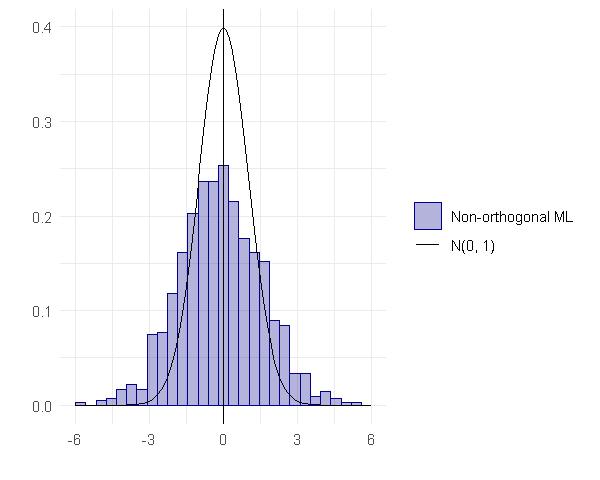

In [4]:
set.seed(1111)

ml_l = lrn("regr.xgboost", nrounds = 50, eta = 0.1)
ml_m = lrn("regr.xgboost", nrounds = 50, eta = 0.1)
ml_g = ml_l$clone()

theta_nonorth = rep(NA, n_rep)
se_nonorth = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)) {
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr_nonorth = DoubleMLPLR$new(obj_dml_data,
                                        ml_l, ml_m, ml_g,
                                        n_folds=2,
                                        score=non_orth_score,
                                        apply_cross_fitting=FALSE)
    obj_dml_plr_nonorth$fit()
    theta_nonorth[i_rep] = obj_dml_plr_nonorth$coef
    se_nonorth[i_rep] = obj_dml_plr_nonorth$se
}

g_nonorth = ggplot(data.frame(theta_rescaled=(theta_nonorth - alpha)/se_nonorth)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Non-orthogonal ML", fill="Non-orthogonal ML"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Non-orthogonal ML", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue", "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Non-orthogonal ML", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

g_nonorth

The regularization bias in the simple ML-approach is caused by the slow convergence of $\hat{\theta}_0$

$$
|\sqrt{n} (\hat{\theta}_0 - \theta_0) | \rightarrow_{P} \infty
$$

i.e., slower than $1/\sqrt{n}$.
The driving factor is the bias that arises by learning $g$ with a random forest or any other ML technique.
A heuristic illustration is given by

$$
\sqrt{n}(\hat{\theta}_0 - \theta_0) = \underbrace{\left(\frac{1}{n} \sum_{i\in I} D_i^2\right)^{-1} \frac{1}{n} \sum_{i\in I} D_i \zeta_i}_{=:a}
+  \underbrace{\left(\frac{1}{n} \sum_{i\in I} D_i^2\right)^{-1} \frac{1}{n} \sum_{i\in I} D_i (g_0(X_i) - \hat{g}_0(X_i))}_{=:b}.
$$

$a$ is approximately Gaussian under mild conditions.
However, $b$ (the regularization bias) diverges in general.

## Overcoming regularization bias by orthogonalization

To overcome the regularization bias we can partial out the effect of $X$ from $D$ to obtain the orthogonalized regressor $V = D - m(X)$. We then use the final estimate

$$
\check{\theta}_0 = \left(\frac{1}{n} \sum_{i\in I} \hat{V}_i D_i\right)^{-1} \frac{1}{n} \sum_{i\in I} \hat{V}_i (Y_i - \hat{g}_0(X_i)).
$$

The following figure shows the distribution of the resulting estimates $\hat{\theta}_0$ without sample-splitting. Again, we are using external predictions to avoid cross-fitting (for demonstration purposes).

Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."


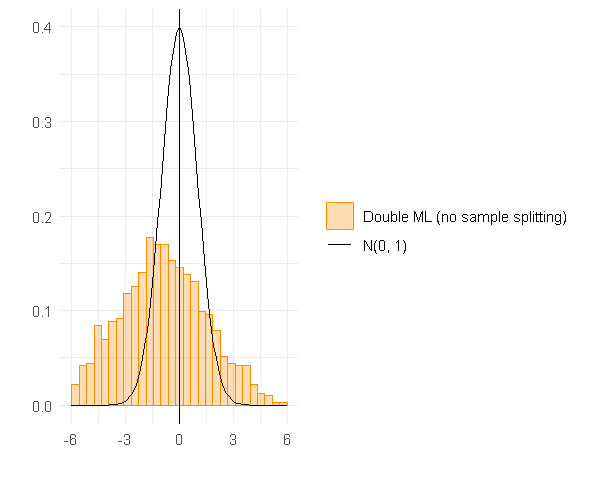

In [5]:
set.seed(2222)

theta_orth_nosplit = rep(NA, n_rep)
se_orth_nosplit = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)){
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr_orth_nosplit = DoubleMLPLR$new(obj_dml_data,
                                        ml_l, ml_m, ml_g,
                                        n_folds=1,
                                        score='IV-type',
                                        apply_cross_fitting=FALSE)
    obj_dml_plr_orth_nosplit$fit()
    theta_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit$coef
    se_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit$se
}

g_nosplit = ggplot(data.frame(theta_rescaled=(theta_orth_nosplit - alpha)/se_orth_nosplit), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

g_nosplit

If the nuisance models $\hat{g}_0()$ and $\hat{m}()$ are estimated on the whole dataset, which is also used for obtaining the final estimate $\check{\theta}_0$, another bias is observed.

## Sample splitting to remove bias induced by overfitting

Using sample splitting, i.e., estimate the nuisance models $\hat{g}_0()$ and $\hat{m}()$ on one part of the data (training data) and estimate $\check{\theta}_0$ on the other part of the data (test data), overcomes the bias induced by overfitting. We can exploit the benefits of cross-fitting by switching the role of the training and test sample. Cross-fitting performs well empirically because the entire sample can be used for estimation.

The following figure shows the distribution of the resulting estimates $\hat{\theta}_0$ with orthogonal score and sample-splitting.

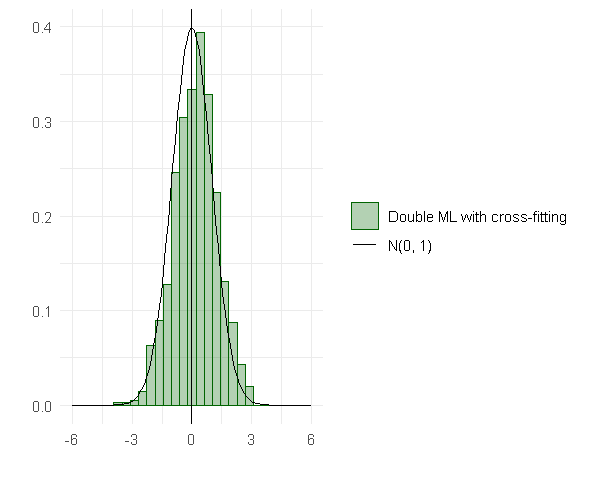

In [6]:
set.seed(3333)

theta_dml = rep(NA, n_rep)
se_dml = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)) {
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr = DoubleMLPLR$new(obj_dml_data,
                                ml_l, ml_m, ml_g,
                                n_folds=2,
                                score='IV-type')
    obj_dml_plr$fit()
    theta_dml[i_rep] = obj_dml_plr$coef
    se_dml[i_rep] = obj_dml_plr$se
}

g_dml = ggplot(data.frame(theta_rescaled=(theta_dml - alpha)/se_dml), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

g_dml

## Double/debiased machine learning

To illustrate the benefits of the auxiliary prediction step in the DML framework we write the error as

$$
\sqrt{n}(\check{\theta}_0 - \theta_0) = a^* + b^* + c^*
$$

Chernozhukov et al. (2018) argues that:

The first term

$$
a^* := (EV^2)^{-1} \frac{1}{\sqrt{n}} \sum_{i\in I} V_i \zeta_i
$$

will be asymptotically normally distributed.

The second term

$$
b^* := (EV^2)^{-1} \frac{1}{\sqrt{n}} \sum_{i\in I} (\hat{m}(X_i) - m(X_i)) (\hat{g}_0(X_i) - g_0(X_i))
$$

vanishes asymptotically for many data generating processes.

The third term $c^*$ vanishes in probability if sample splitting is applied. Finally, let us compare all distributions.

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"
Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."


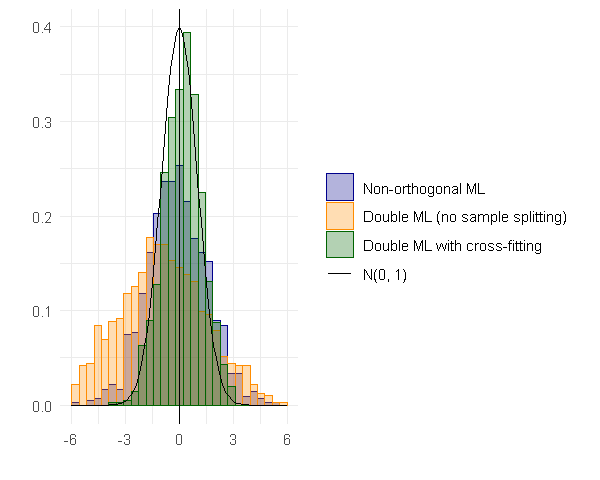

In [7]:
g_all = ggplot(data.frame(t_nonorth=(theta_nonorth - alpha)/se_nonorth,
                        t_orth_nosplit=(theta_orth_nosplit - alpha)/se_orth_nosplit,
                        t_dml=(theta_dml - alpha)/se_dml)) +
                geom_histogram(aes(x = t_nonorth, y=after_stat(density), colour = "Non-orthogonal ML", fill="Non-orthogonal ML"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_orth_nosplit, y=after_stat(density), colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_dml, y=after_stat(density), colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                                bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"=NA)) +
            xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()

print(g_all)

## Partialling out score

Another debiased estimator, based on the partialling-out approach of Robinson(1988), is

$$
\check{\theta}_0 = \left(\frac{1}{n} \sum_{i\in I} \hat{V}_i \hat{V}_i \right)^{-1} \frac{1}{n} \sum_{i\in I} \hat{V}_i (Y_i - \hat{\ell}_0(X_i)),
$$

with $\ell_0(X_i) = E(Y|X)$.
All nuisance parameters for the estimator with `score='partialling out'` are conditional mean functions, which can be directly estimated using ML methods. This is a minor advantage over the estimator with `score='IV-type'`.
In the following, we repeat the above analysis with `score='partialling out'`. In a first part of the analysis, we estimate $\theta_0$ without sample splitting. Again we observe a bias from overfitting.

The following figure shows the distribution of the resulting estimates $\hat{\theta}_0$ without sample-splitting.

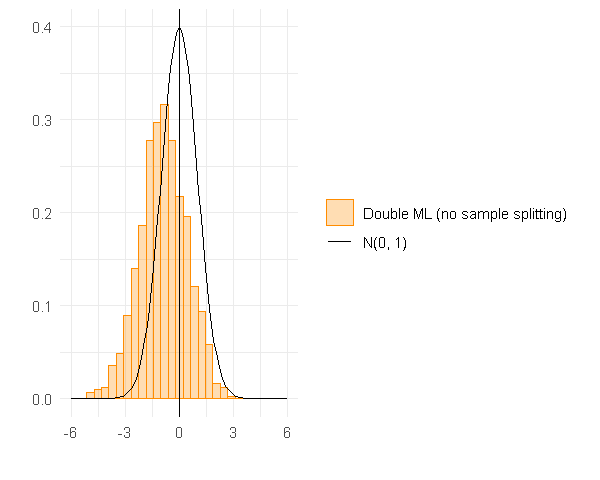

In [8]:
set.seed(4444)

theta_orth_po_nosplit = rep(NA, n_rep)
se_orth_po_nosplit = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)){
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr_orth_nosplit = DoubleMLPLR$new(obj_dml_data,
                                            ml_l, ml_m,
                                            n_folds=1,
                                            score='partialling out',
                                            apply_cross_fitting=FALSE)
    obj_dml_plr_orth_nosplit$fit()
    theta_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit$coef
    se_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit$se
}

g_nosplit_po = ggplot(data.frame(theta_rescaled=(theta_orth_po_nosplit - alpha)/se_orth_po_nosplit), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"='black')) +
                scale_fill_manual(name='',,
                    breaks=c("Double ML (no sample splitting)", "N(0, 1)"),
                    values=c("Double ML (no sample splitting)"="dark orange", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()
g_nosplit_po

Using sample splitting, overcomes the bias induced by overfitting.
Again, the implementation automatically applies cross-fitting.

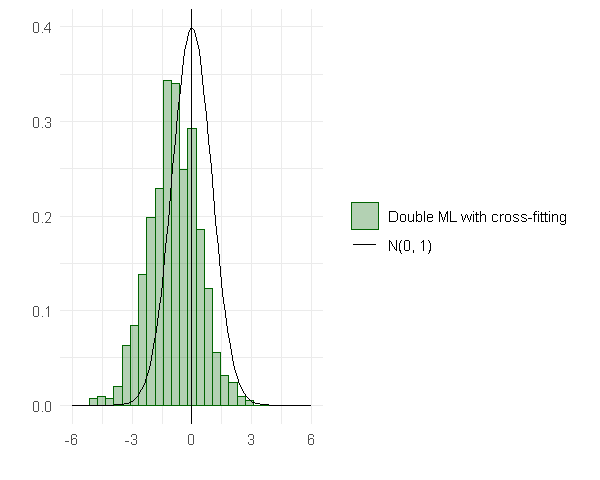

In [9]:
set.seed(5555)

theta_dml_po = rep(NA, n_rep)
se_dml_po = rep(NA, n_rep)

for (i_rep in seq_len(n_rep)) {
    cat(sprintf("Replication %d/%d", i_rep, n_rep), "\r", sep="")
    flush.console()
    df = data[[i_rep]]
    obj_dml_data = double_ml_data_from_data_frame(df, y_col = "y", d_cols = "d")
    obj_dml_plr = DoubleMLPLR$new(obj_dml_data,
                                ml_l, ml_m,
                                n_folds=2,
                                score='partialling out')
    obj_dml_plr$fit()
    theta_dml_po[i_rep] = obj_dml_plr$coef
    se_dml_po[i_rep] = obj_dml_plr$se
}

g_dml_po = ggplot(data.frame(theta_rescaled=(theta_dml_po - alpha)/se_dml_po), aes(x = theta_rescaled)) +
                geom_histogram(aes(y=after_stat(density), x=theta_rescaled, colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                            bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"='black')) +
                scale_fill_manual(name='',,
                    breaks=c("Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Double ML with cross-fitting"="dark green", "N(0, 1)"=NA)) +
                xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()
g_dml_po

Finally, let us compare all distributions.

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"


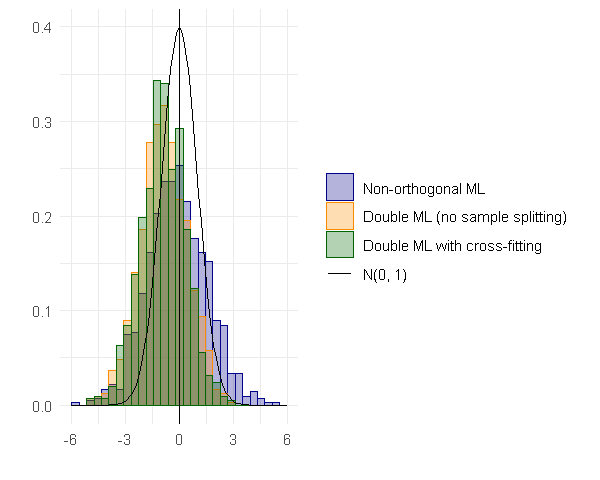

In [10]:
g_all_po = ggplot(data.frame(t_nonorth=(theta_nonorth - alpha)/se_nonorth,
                        t_orth_nosplit=(theta_orth_po_nosplit - alpha)/se_orth_po_nosplit,
                        t_dml=(theta_dml_po - alpha)/se_dml_po)) +
                geom_histogram(aes(x = t_nonorth, y=after_stat(density), colour = "Non-orthogonal ML", fill="Non-orthogonal ML"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_orth_nosplit, y=after_stat(density), colour = "Double ML (no sample splitting)", fill="Double ML (no sample splitting)"),
                                bins = 30, alpha = 0.3) +
                geom_histogram(aes(x = t_dml, y=after_stat(density), colour = "Double ML with cross-fitting", fill="Double ML with cross-fitting"),
                                bins = 30, alpha = 0.3) +
                geom_vline(aes(xintercept = 0), col = "black") +
                suppressWarnings(geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill="N(0, 1)"))) +
                scale_color_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"='black')) +
                scale_fill_manual(name='',
                    breaks=c("Non-orthogonal ML", "Double ML (no sample splitting)", "Double ML with cross-fitting", "N(0, 1)"),
                    values=c("Non-orthogonal ML"="dark blue",
                            "Double ML (no sample splitting)"="dark orange",
                            "Double ML with cross-fitting"="dark green",
                            "N(0, 1)"=NA)) +
            xlim(c(-6.0, 6.0)) + xlab("") + ylab("") + theme_minimal()
g_all_po

In [11]:
# save all plots
ggsave(filename = "../guide/figures/r_non_orthogonal.svg", plot = g_nonorth, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_dml_nosplit.svg", plot = g_nosplit, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_dml.svg", plot = g_dml, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_all.svg", plot = g_all, dpi = 300, units = "in", width = 6, height = 4)

ggsave(filename = "../guide/figures/r_dml_po_nosplit.svg", plot = g_nosplit_po, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_dml_po.svg", plot = g_dml_po, dpi = 300, units = "in", width = 6, height = 4)
ggsave(filename = "../guide/figures/r_po_all.svg", plot = g_all_po, dpi = 300, units = "in", width = 6, height = 4)

Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"
Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"
Warning message:
"Removed 21 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message in geom_function(fun = dnorm, aes(colour = "N(0, 1)", fill = "N(0, 1)")):
"All aesthetics have length 1, but the data has 1000 rows.
ℹ Did you mean to use `annotate()`?"
